In [1]:
import json
import matplotlib
import warnings

warnings.simplefilter('ignore')
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

In [2]:
import pandas as pd
data_returns = pd.read_csv("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/pymc3/training/data/SP500.csv",
                           index_col = 0, parse_dates = True)

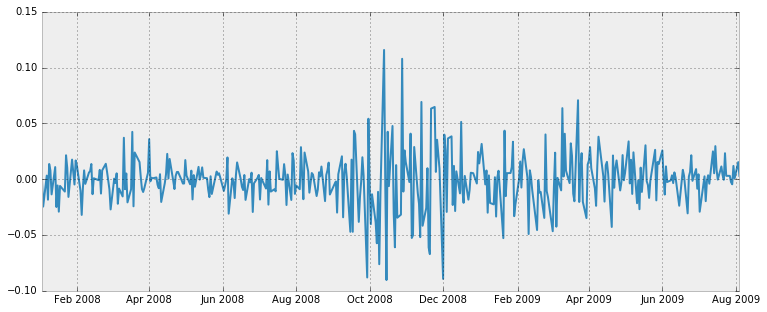

In [3]:
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline

figsize(12.5, 5)
plt.plot(data_returns);

### Case study 1: Stochastic volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3's use in addressing a more realistic problem. The distribution of market returns is<b> highly non-normal</b>, which makes <i>sampling the volatlities significantly more difficult</i>.

This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS as expalin in the first training, which is dramatically more efficient.

### The Model

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

$$\begin{aligned} 
  \sigma &\sim exp(50) \\
  \nu &\sim exp(.1) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^{-2}) \\
  log(y_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}$$

Here, $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process. 


### Model Specification

As with the linear regession example, specifying the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the `Exponential` distribution for the $ \nu $ and $\sigma$ priors, the student-t (`T`) distribution for distribution of returns, and the `GaussianRandomWalk` for the prior for the latent volatilities.   

In PyMC3, variables with purely positive priors like `Exponential` are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named "variableName_log") is added to the model for sampling. 

In this model this happens behind the scenes for both the degrees of freedom, `nu`, and the scale parameter for the volatility process, `sigma`, since they both have exponential priors. Variables with priors that constrain them on two sides, like `Beta` or `Uniform`, are also transformed to be unconstrained but with a log odds transform. 

We can also provide an initial value for any distribution (called a "test value") using the `testval` argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden. 

The vector of latent volatilities `s` is given a prior distribution by `GaussianRandomWalk`.

As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the `shape` argument. The scale of the innovations of the random walk, `sigma`, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector. 

In [4]:
import pymc3 as pm
import theano.tensor as T
import scipy

with pm.Model() as SP500_model:
    
    nu = pm.Exponential("nu", 1. / 10, testval = 50)
    sigma = pm.Exponential("sigma", 1. / .02, testval = .1)
    s = pm.GaussianRandomWalk("s", sigma**-2, shape = len(data_returns))
    
    volatility_process = pm.Deterministic("volatility_process", T.exp(-2*s))
    
    observation = pm.StudentT("obs", nu, lam = 1 / volatility_process, observed = data_returns["S&P500"])

### Fitting

Before we draw samples from the posterior, it is prudent to find a decent starting value by finding a point of relatively high probability (MAP). 

For this model, the full *maximum a posteriori* (MAP) point over all variables is degenerate and has infinite density. But, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect only to the volatility process `s` keeping `log_sigma` and `nu` constant at their default values (remember that we set `testval=.1` for `sigma`).

We use the Limited-memory BFGS (L-BFGS) optimizer, which is provided by the `scipy.optimize` package, as it is more efficient for high dimensional functions and we have 400 stochastic random variables (mostly from `s`).

To do the sampling, we do a short initial run to put us in a volume of high probability, then start again at the new starting point. `trace[-1]` gives us the last point in the sampling trace. 

NUTS will recalculate the scaling parameters based on the new point, and in this case it leads to faster sampling due to better scaling.

In [5]:
with SP500_model:
    start = pm.find_MAP(vars = [s], fmin = scipy.optimize.fmin_l_bfgs_b)
    step = pm.NUTS(scaling = start)
    
    trace = pm.sample(20000, step = step, start = start)
    burned_trace = trace[10000:]

100%|██████████| 20000/20000 [19:25<00:00, 17.16it/s]


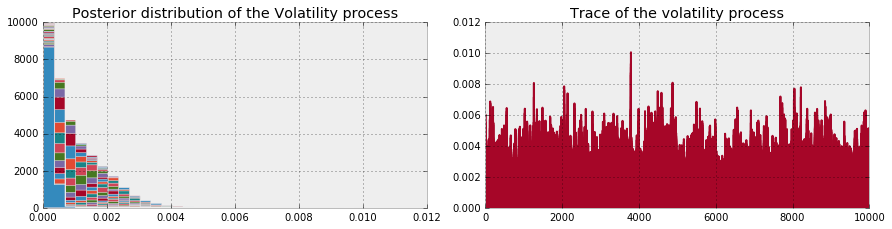

In [6]:
samples_volatility_process = burned_trace["volatility_process"]

figsize(12.5, 6)
fig = plt.figure()
fig.add_subplot(2, 2, 1)
plt.title("Posterior distribution of the Volatility process")
plt.hist(samples_volatility_process, histtype = "stepfilled", bins = 30, )

fig.add_subplot(2, 2, 2)
plt.title("Trace of the volatility process")
plt.plot(samples_volatility_process, c = colors[1])
plt.tight_layout()

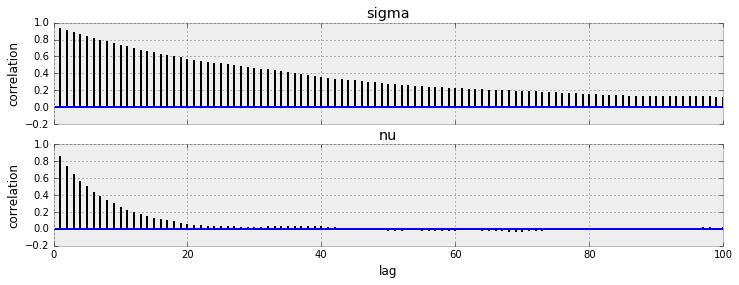

In [9]:
pm.plots.autocorrplot(trace = burned_trace, varnames = ["sigma", "nu"]);

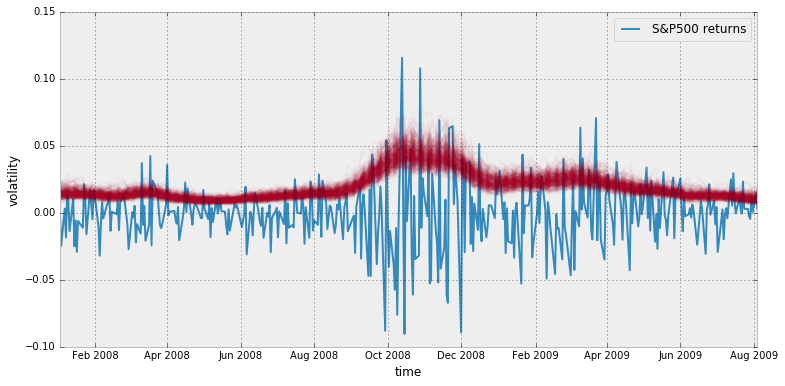

In [11]:
import numpy as np
figsize(12.5, 6)

plt.plot(data_returns, label = "S&P500 returns")
plt.plot(data_returns.index, 1. / np.exp(burned_trace['s',::30].T), c = colors[1], alpha = .03)
plt.xlabel("time")
plt.ylabel("volatility")
plt.legend(loc = "upper right");

### Poisson Process modelling

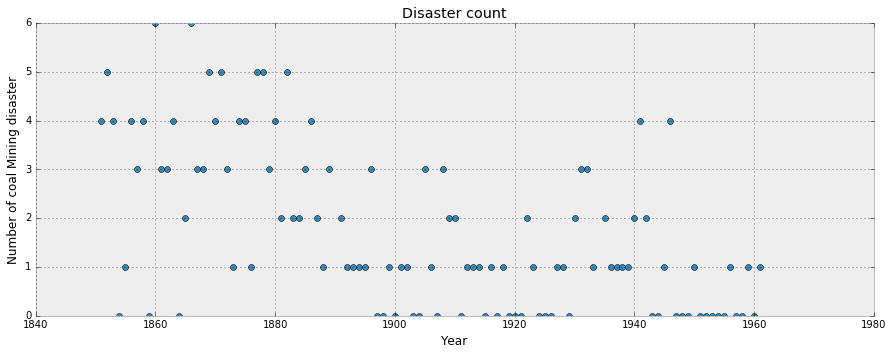

In [12]:
import numpy as np
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value = -999)
year = np.arange(1851, 1962)

#plots
figsize(12.5, 5)
fig = plt.figure()
plt.title("Disaster count")
plt.plot(year, disaster_data ,'o', markersize = 6)
plt.xlabel("Year")
plt.ylabel("Number of coal Mining disaster")
plt.tight_layout()

#### Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model, 

$$ 
\begin{aligned}  
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases} 
   l, & \text{if } t \lt s \\
   e, & \text{if } t \ge s 
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\         
  e &\sim \text{exp}(\alpha)\\
  l &\sim \text{exp}(\alpha)    
\end{aligned}
$$
 the parameters are defined as follows: 
   * $D_t$: The number of disasters in year $t$
   * $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$.
   * $s$: The year in which the rate parameter changes (the switchpoint).
   * $e$: The rate parameter before the switchpoint $s$.
   * $l$: The rate parameter after the switchpoint $s$.
   * $t_l$, $t_h$: The lower and upper boundaries of year $t$.
   
This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [13]:
with pm.Model()as disaster_model:
    
    alpha = 1. / disaster_data.mean()
    
    early_rate = pm.Exponential("early_rate", alpha)
    late_rate = pm.Exponential("late_rate", alpha)
    
    switch_point = pm.DiscreteUniform("switch_point", lower = year.min(), upper = year.max(), testval = 1900)
    
    rate = pm.math.switch(switch_point >= year, early_rate, late_rate)
    
    disaster_obs = pm.Poisson("obs", rate, observed = disaster_data)

In [14]:
# here we will use metropolis for sample, we don't have much continuous variables
# Thus NUTS is not that necessary
with disaster_model:
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.Metropolis()
    
    trace = pm.sample(20000, step = step, start = start )
    burned_trace = trace[10000:]

Optimization terminated successfully.
         Current function value: 183.787891
         Iterations: 2
         Function evaluations: 44


100%|██████████| 20000/20000 [00:09<00:00, 2193.46it/s]


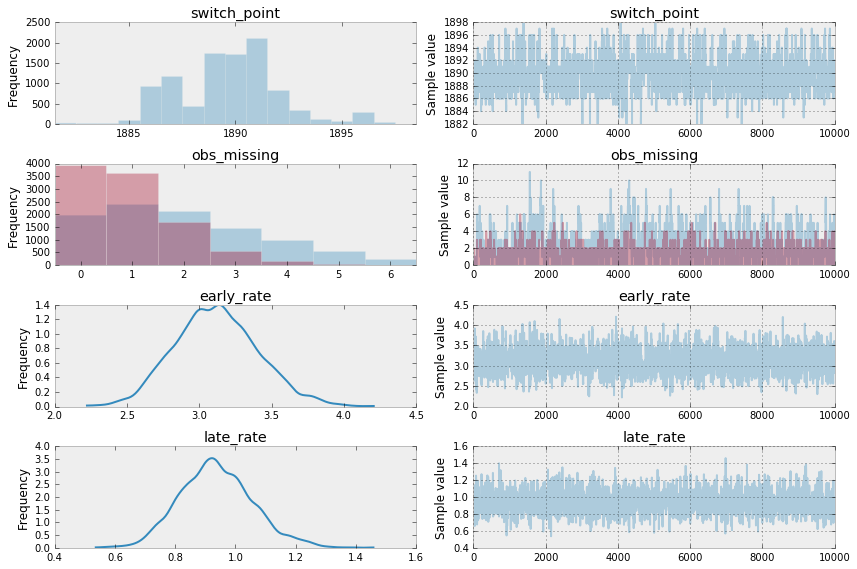

In [19]:
pm.plots.traceplot(trace = burned_trace);

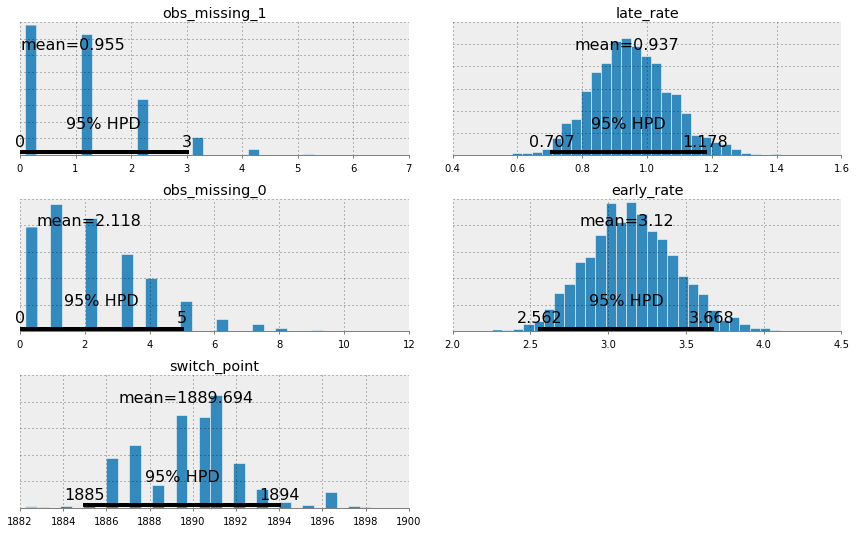

In [20]:
pm.plots.plot_posterior(trace = burned_trace);

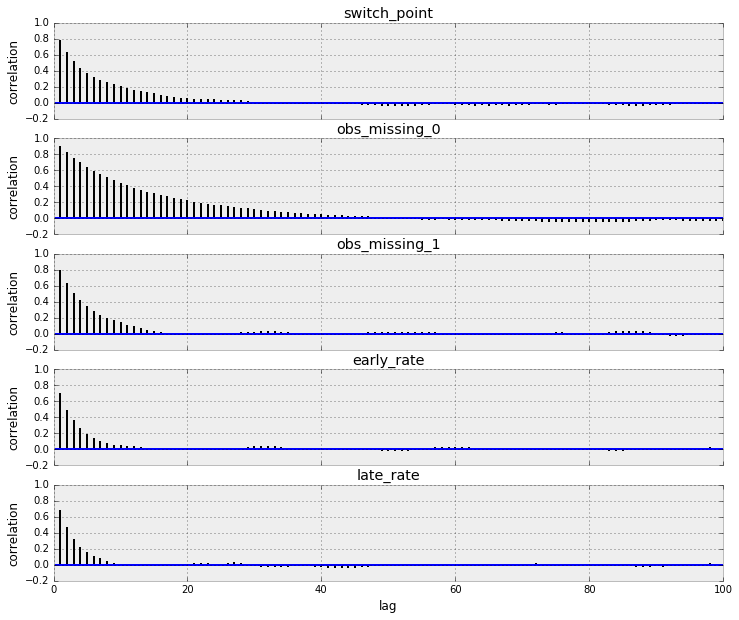

In [21]:
pm.plots.autocorrplot(trace= burned_trace);

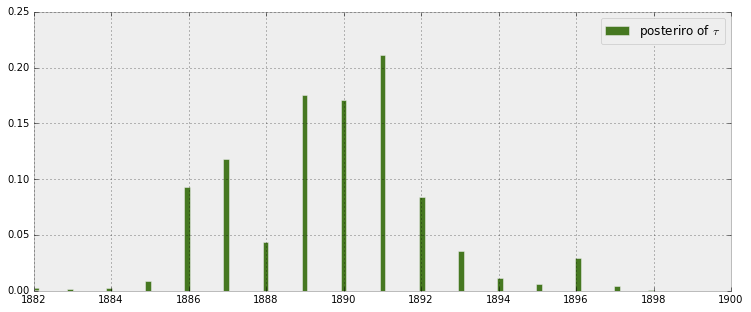

In [22]:
w = 1.0 / burned_trace["switch_point"].shape[0] * np.ones_like(burned_trace["switch_point"])
plt.hist(burned_trace["switch_point"], bins = len(disaster_data),  alpha = 1, label = r"posteriro of $\tau$",
        color = "#467821", weights = w, rwidth = 2.)
plt.legend();

In [23]:
_year = 1960
idx = _year < burned_trace["switch_point"]
(burned_trace["early_rate"][idx].sum() + burned_trace["late_rate"][~idx].sum())/burned_trace["switch_point"].shape[0]

0.93739306434227931